# Data exploration - Swap gas usage for top Rollups

#### Maria Silva, August 2024

In [1]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import KernelDensity

In [2]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))

In [3]:
paper_template = dict(
    layout=go.Layout(
        template="simple_white",
        font=dict(size=14, family="Clear Sans"),
        margin=go.layout.Margin(
            l=40,  # left margin
            r=40,  # right margin
            b=40,  # bottom margin
            t=40,  # top margin
        ),
        width=700,
        xaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        yaxis=dict(
            automargin=True, minor_ticks="inside", showgrid=True, griddash="dash", minor_griddash="dot"
        ),
        )
)

## Load and clean data

In [4]:
file_path = os.path.join(data_dir, "dune_fail_swap_traces.csv")
fail_swap_traces_df = pd.read_csv(file_path, low_memory=False)

fail_swap_traces_df["block_time"] = pd.to_datetime(fail_swap_traces_df["block_time"])

traces_by_tx = (
    fail_swap_traces_df
    .groupby(["blockchain", "tx_hash"])
    .size()
    .reset_index()
    .rename(columns={0:"traces_by_tx"})
)
fail_swap_traces_df = fail_swap_traces_df.merge(traces_by_tx, how="left", on=["blockchain", "tx_hash"])

fail_swap_traces_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307701 entries, 0 to 307700
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   blockchain            307701 non-null  object             
 1   block_time            307701 non-null  datetime64[ns, UTC]
 2   tx_hash               307701 non-null  object             
 3   gas_units_used_tx     307701 non-null  int64              
 4   trace_address         307701 non-null  object             
 5   gas_trace             307701 non-null  int64              
 6   gas_units_used_trace  307701 non-null  int64              
 7   error                 307701 non-null  object             
 8   traces_by_tx          307701 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 21.1+ MB


## Failed swaps - overview

In [5]:
# Failed swap traces per blockchain
fail_swap_traces_df.groupby("blockchain").size()

blockchain
arbitrum    129285
base        168369
optimism     10044
zksync           3
dtype: int64

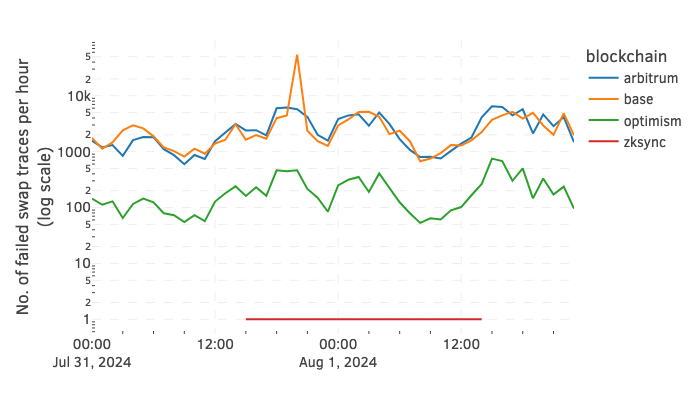

In [6]:
# Fails per hour
temp_df = fail_swap_traces_df.groupby(["blockchain", pd.Grouper(key="block_time", freq="h")]).size().reset_index()
fig = px.line(temp_df, x="block_time", y=0, template=paper_template, height=400, color="blockchain", log_y=True)
fig.update_layout(xaxis_title="", yaxis_title="No. of failed swap traces per hour<br>(log scale)")
fig.show('png')

In [7]:
# Fail errors
fail_swap_traces_df.groupby([ "blockchain", "error"]).size().reset_index()

,blockchain,error,0
0,arbitrum,execution reverted,129285
1,base,execution reverted,168369
2,optimism,execution reverted,10044
3,zksync,Panic,3


In [8]:
# Traces per transaction
fail_swap_traces_df.groupby("traces_by_tx").size()

traces_by_tx
1     278763
2      24212
3       1974
4       2128
5        495
6         30
8         48
9         27
12        24
dtype: int64

## Failed swaps - gas usage

In [9]:
# Gas units per swap trace
(
    fail_swap_traces_df
    .groupby("blockchain")
    ["gas_units_used_trace"]
    .agg(["mean", "std", "median", "min", "max"])
    .round(2)
)

,mean,std,median,min,max
blockchain,,,,,
arbitrum,93837.10,181400.22,8779.0,658,7902582
base,57032.71,91679.09,23574.0,658,3384366
optimism,52532.26,199370.91,3285.0,710,10018810
zksync,251034.00,283241.11,89019.0,85995,578088


In [10]:
# Gas units per swap trace - single swap trace txs
(
    fail_swap_traces_df[fail_swap_traces_df["traces_by_tx"]==1]
    .groupby("blockchain")
    ["gas_units_used_trace"]
    .agg(["mean", "std", "median", "min", "max"])
    .round(2)
)

,mean,std,median,min,max
blockchain,,,,,
arbitrum,91568.42,179249.33,8779.0,658,7902582
base,49271.73,81133.03,23574.0,658,3384366
optimism,47862.99,197459.22,3285.0,710,10018810
zksync,251034.00,283241.11,89019.0,85995,578088


In [11]:
# Gas units per transaction
(
    fail_swap_traces_df
    .groupby("blockchain")
    ["gas_units_used_tx"]
    .agg(["mean", "std", "median", "min", "max"])
    .round(2)
)

,mean,std,median,min,max
blockchain,,,,,
arbitrum,201300.18,206423.37,141321.0,28221,8043835
base,158933.48,178727.22,120429.0,33022,5319533
optimism,135743.58,302324.40,63723.0,33222,12567967
zksync,819619.33,78386.00,848603.0,730869,879386


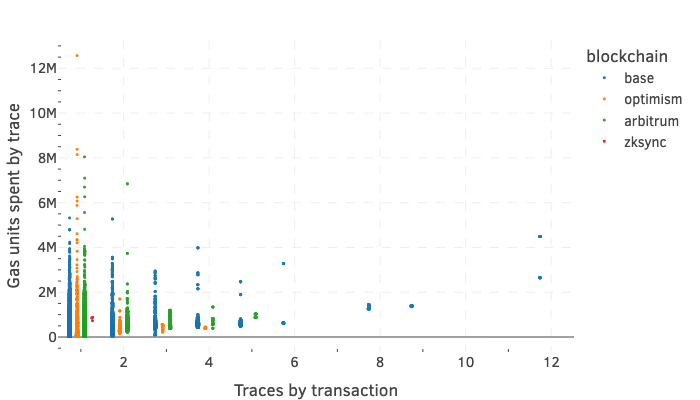

In [12]:
# Gas units per swap trace vs. swap traces per tx
fig = px.strip(fail_swap_traces_df, y="gas_units_used_tx", x="traces_by_tx", 
               template=paper_template, height=400, color="blockchain")
fig.update_layout(xaxis_title="Traces by transaction", yaxis_title="Gas units spent by trace")
fig.update_traces({'marker':{'size': 3}})
fig.show('png')

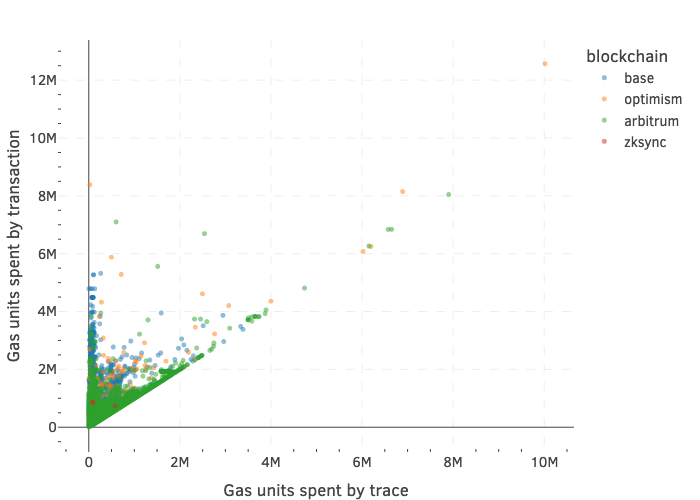

In [13]:
# Gas units used by trace vs. Gas units used by transaction)
fig = px.scatter(fail_swap_traces_df, x="gas_units_used_trace", y="gas_units_used_tx", opacity=0.5,
               template=paper_template, color="blockchain")
fig.update_layout(xaxis_title="Gas units spent by trace", yaxis_title="Gas units spent by transaction")
fig.update_traces({'marker':{'size': 5}})
fig.show('png')

## Previous code - Failure rates

In [ ]:
fail_series = swap_txs_df.groupby("blockchain")["success"].apply(lambda x: (x==False).sum())
count_series = swap_txs_df.groupby("blockchain").size()

fail_series/count_series

In [ ]:
temp_df = (
    swap_txs_df[swap_txs_df["blockchain"]=="optimism"]
    .groupby(pd.Grouper(key="block_time",freq='W'))
    ["success"]
    .mean()
    .reset_index()
    )
temp_df["fail_rate"] = 1-temp_df["success"]

fig = px.line(temp_df, x="block_time", y="fail_rate", template=paper_template, height=400)
fig.update_layout(xaxis_title="Gas used (units)", yaxis_title="Count")
fig.show('png')